Kaggle link: https://www.kaggle.com/c/home-credit-default-risk

### 1. Importing packages

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, StackingClassifier
import xgboost
import lightgbm

### 2. Loading datasets and Feature engineering

In [ ]:
# reading train data + exam data, then combining them for preprocessing
XY_all = pd.read_csv('application_train.csv', index_col=0)

Y_all = XY_all[['TARGET']]
X_all = XY_all.drop('TARGET', axis=1)
X_exam = pd.read_csv('application_test.csv', index_col=0)

X_combined0 = pd.concat([X_all, X_exam], axis=0)
print(X_combined0.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100002 to 456250
Columns: 120 entries, NAME_CONTRACT_TYPE to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(39), object(16)
memory usage: 328.9+ MB
None


In [ ]:
# removing columns with missing values more than 20%
X_null = X_combined0.isnull().sum(axis=0)
max_na = X_combined0.shape[0] * 0.2
col = [c for c in X_combined0.columns if X_null[c] <= max_na]
X_combined1 = X_combined0[col]
print(X_combined1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100002 to 456250
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           356255 non-null  object 
 1   CODE_GENDER                  356255 non-null  object 
 2   FLAG_OWN_CAR                 356255 non-null  object 
 3   FLAG_OWN_REALTY              356255 non-null  object 
 4   CNT_CHILDREN                 356255 non-null  int64  
 5   AMT_INCOME_TOTAL             356255 non-null  float64
 6   AMT_CREDIT                   356255 non-null  float64
 7   AMT_ANNUITY                  356219 non-null  float64
 8   AMT_GOODS_PRICE              355977 non-null  float64
 9   NAME_TYPE_SUITE              354052 non-null  object 
 10  NAME_INCOME_TYPE             356255 non-null  object 
 11  NAME_EDUCATION_TYPE          356255 non-null  object 
 12  NAME_FAMILY_STATUS           356255 non-null  object 

In [ ]:
num_cols = X_combined1.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_combined1.select_dtypes(include='object').columns.tolist()
        
print ("Cardinal columns = ", len(num_cols))
print ("Categorical columns = ", len(cat_cols))

Cardinal columns =  59
Categorical columns =  11


In [ ]:
# imputation of cardinal (numeric) columns
num_imputer = SimpleImputer(strategy='mean')
X_combined2 = X_combined1.copy()
X_combined2[num_cols] = num_imputer.fit_transform(X_combined1[num_cols])

# imputation of categorical columns
for col in cat_cols:
    v = X_combined2[col].mode()[0]
    X_combined2[col].fillna(value=v)

print(X_combined2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100002 to 456250
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           356255 non-null  object 
 1   CODE_GENDER                  356255 non-null  object 
 2   FLAG_OWN_CAR                 356255 non-null  object 
 3   FLAG_OWN_REALTY              356255 non-null  object 
 4   CNT_CHILDREN                 356255 non-null  float64
 5   AMT_INCOME_TOTAL             356255 non-null  float64
 6   AMT_CREDIT                   356255 non-null  float64
 7   AMT_ANNUITY                  356255 non-null  float64
 8   AMT_GOODS_PRICE              356255 non-null  float64
 9   NAME_TYPE_SUITE              354052 non-null  object 
 10  NAME_INCOME_TYPE             356255 non-null  object 
 11  NAME_EDUCATION_TYPE          356255 non-null  object 
 12  NAME_FAMILY_STATUS           356255 non-null  object 

In [ ]:
str_imputer = SimpleImputer(strategy='most_frequent')
X_combined2['NAME_TYPE_SUITE'] = str_imputer.fit_transform(X_combined1[['NAME_TYPE_SUITE']])

In [ ]:
print(X_combined2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100002 to 456250
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           356255 non-null  object 
 1   CODE_GENDER                  356255 non-null  object 
 2   FLAG_OWN_CAR                 356255 non-null  object 
 3   FLAG_OWN_REALTY              356255 non-null  object 
 4   CNT_CHILDREN                 356255 non-null  float64
 5   AMT_INCOME_TOTAL             356255 non-null  float64
 6   AMT_CREDIT                   356255 non-null  float64
 7   AMT_ANNUITY                  356255 non-null  float64
 8   AMT_GOODS_PRICE              356255 non-null  float64
 9   NAME_TYPE_SUITE              356255 non-null  object 
 10  NAME_INCOME_TYPE             356255 non-null  object 
 11  NAME_EDUCATION_TYPE          356255 non-null  object 
 12  NAME_FAMILY_STATUS           356255 non-null  object 

In [ ]:
# converting categorical var. to dummy var.
X_combined3 = pd.get_dummies(X_combined2)

### 3. Advanced tree based models

In [ ]:
# extracting exam data from pre-processed combined data
def split_train_exam(X_combined, n):
    X_task = X_combined.iloc[:n,:]
    X_exam = X_combined.iloc[n:,:]
    return X_task, X_exam

# computing R^2 & RMSE and printing them
def model_perf(model, X, Y, prefix=''):
    p_hat = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(Y, p_hat)
    print (f'{prefix} AUROC score = {auc:.3f}')

# cross validation not included because of computation time
def model_fit_perf(model, X_all, Y_all, prefix=''):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=4)
    model.fit(X_trn, Y_trn)
    print (prefix)
    model_perf(model, X_trn, Y_trn, '  Training  ')
    model_perf(model, X_val, Y_val, '  Validation')

In [ ]:
X_task2, X_exam2 = split_train_exam(X_combined3, X_all.shape[0])

In [ ]:
# LGBM classifier
lgbm_c = lightgbm.LGBMClassifier()
model_fit_perf(lgbm_c, X_task2, Y_all, "LGBM")

LGBM
  Training   AUROC score = 0.792
  Validation AUROC score = 0.749


In [ ]:
# random forest classifier
random_forest_c = RandomForestClassifier(n_estimators=50)
model_fit_perf(random_forest_c, X_task2, Y_all, "Random Forest")

Random Forest
  Training   AUROC score = 1.000
  Validation AUROC score = 0.697


In [ ]:
# XGB classifier
xgb_c = xgboost.XGBClassifier()
model_fit_perf(xgb_c, X_task2, Y_all, "XGBoost")

XGBoost
  Training   AUROC score = 0.753
  Validation AUROC score = 0.743


In [ ]:
# stacking ensemble
estms = [('lgbm', lgbm_c), ('rf', random_forest_c), ('xgb', xgb_c)]
stacking_c = StackingClassifier(estimators=estms, final_estimator=lightgbm.LGBMClassifier())
model_fit_perf(stacking_c, X_task2, Y_all, "Stacking Ensemble")

Stacking Ensemble
  Training   AUROC score = 0.882
  Validation AUROC score = 0.749


### 4. Results

In [ ]:
p = stacking_c.predict_proba(X_exam2)

submission_df = pd.read_csv('sample_submission.csv', index_col=0)
submission_df['TARGET'] = p[:,1]

submission_df.to_csv('mysub.csv')

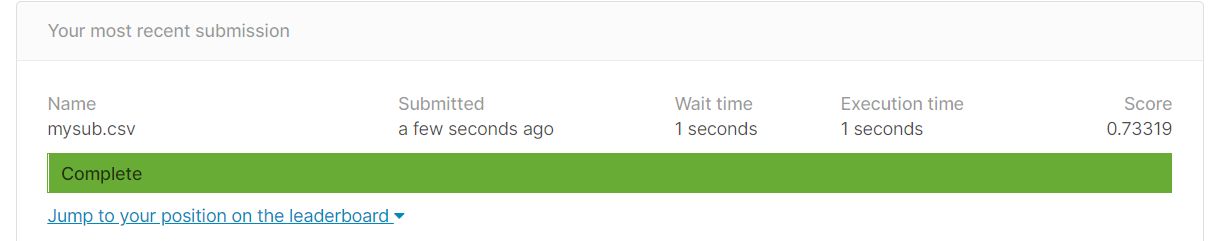